This Jupyter Notebook explores diabetes prediction through a machine learning model using a dataset with health metrics and lifestyle factors. Exploratory data analysis reveals relationships between features and diabetes likelihood. Moreover, for hyperparameter optimization Hyperopt library is used and the process involves searching for the best set of hyperparameters for a machine learning model to achieve optimal performance. After developing the model, it will be deployed on Google Cloud in the future. 

Dataset can be found on https://www.kaggle.com/datasets/iammustafatz/diabetes-prediction-dataset

In [1]:
#imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb

from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from hyperopt import fmin, tpe, hp, Trials, STATUS_OK

from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split, cross_val_score,\
                                    cross_validate,cross_val_score, StratifiedKFold

from sklearn.metrics import make_scorer, matthews_corrcoef, confusion_matrix, f1_score, log_loss, roc_auc_score,\
                             accuracy_score, roc_curve, fbeta_score, ConfusionMatrixDisplay,\
                            precision_score, classification_report, balanced_accuracy_score
import joblib as jb
import warnings

In [2]:
%load_ext autoreload
%autoreload 2

In [4]:
#helper func to calculate f2 score

def f2_func(y_true, y_pred):
    f2_score = fbeta_score(y_true, y_pred, beta=2)
    return f2_score
f2_scorer = make_scorer(f2_func, greater_is_better=True)

### data upload

In [6]:
df = pd.read_csv("data/diabetes_prediction_dataset.csv")

In [7]:
df.shape

(100000, 9)

In [8]:
df.head(3)

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0


## EDA

In [9]:
df.describe(include = 'all')

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
count,100000,100000.000000,100000.00000,100000.000000,100000,100000.000000,100000.000000,100000.000000,100000.000000
unique,3,NaN,NaN,NaN,6,NaN,NaN,NaN,NaN
top,Female,NaN,NaN,NaN,No Info,NaN,NaN,NaN,NaN
freq,58552,NaN,NaN,NaN,35816,NaN,NaN,NaN,NaN
mean,NaN,41.885856,0.07485,0.039420,NaN,27.320767,5.527507,138.058060,0.085000
std,NaN,22.516840,0.26315,0.194593,NaN,6.636783,1.070672,40.708136,0.278883
min,NaN,0.080000,0.00000,0.000000,NaN,10.010000,3.500000,80.000000,0.000000
25%,NaN,24.000000,0.00000,0.000000,NaN,23.630000,4.800000,100.000000,0.000000
50%,NaN,43.000000,0.00000,0.000000,NaN,27.320000,5.800000,140.000000,0.000000
75%,NaN,60.000000,0.00000,0.000000,NaN,29.580000,6.200000,159.000000,0.000000


In [10]:
#unique values in gender variable
df.gender.unique()

array(['Female', 'Male', 'Other'], dtype=object)

In [11]:
#unique values in smoking history variable
df.smoking_history.unique()

array(['never', 'No Info', 'current', 'former', 'ever', 'not current'],
      dtype=object)

In [12]:
#Checking missing data and duplicated values
df.isna().sum()

gender                 0
age                    0
hypertension           0
heart_disease          0
smoking_history        0
bmi                    0
HbA1c_level            0
blood_glucose_level    0
diabetes               0
dtype: int64

In [13]:
df.duplicated().sum()

3854

In [14]:
# Getting the dataframe without duplicated rows
df = df.drop_duplicates()
df.shape

(96146, 9)

## we will check distribution of the each feature

In [15]:
df.gender.value_counts(normalize = True)

gender
Female    0.584122
Male      0.415691
Other     0.000187
Name: proportion, dtype: float64

In [16]:
#since there are only 18 values out of 1M that represent Other categories so will drop those 18 values
df = df.query("gender != 'Other'").reset_index(drop=True)

gender
Female    56161
Male      39967
Name: count, dtype: int64


<Axes: xlabel='gender', ylabel='count'>

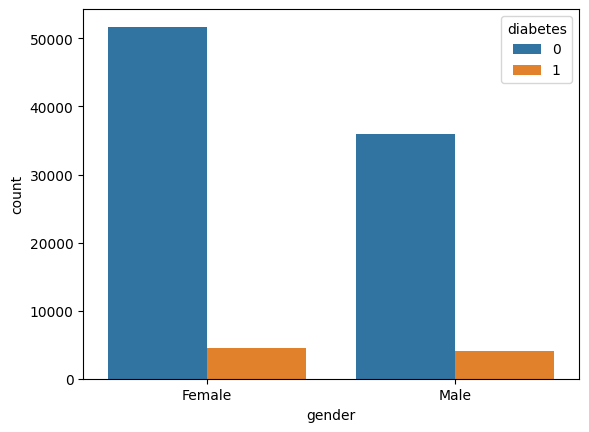

In [17]:
print(df['gender'].value_counts())
sns.countplot(data = df, x = 'gender', hue = 'diabetes')

In [18]:
df[['gender','diabetes']].groupby(by='gender').agg(['mean','count'])

diabetes       
            mean  count
gender                 
Female  0.079183  56161
Male    0.100958  39967

Males had a higher incidence of diabetes at 10%, compared to females at 7%.

In [19]:
df.smoking_history.value_counts(normalize = True)

smoking_history
never          0.357804
No Info        0.342054
former         0.096736
current        0.095675
not current    0.066151
ever           0.041580
Name: proportion, dtype: float64

In [20]:
# Checking the diabetes mean and count for hypertension
df[['hypertension','diabetes']].groupby(by='hypertension').agg(['mean','count'])

diabetes       
                  mean  count
hypertension                 
0             0.072135  88667
1             0.279587   7461

More people with high blood pressure (28%) had diabetes compared to those without high blood pressure (7%).

In [21]:
df.heart_disease.value_counts()

heart_disease
0    92205
1     3923
Name: count, dtype: int64

heart_disease
0    92205
1     3923
Name: count, dtype: int64


<Axes: xlabel='heart_disease', ylabel='count'>

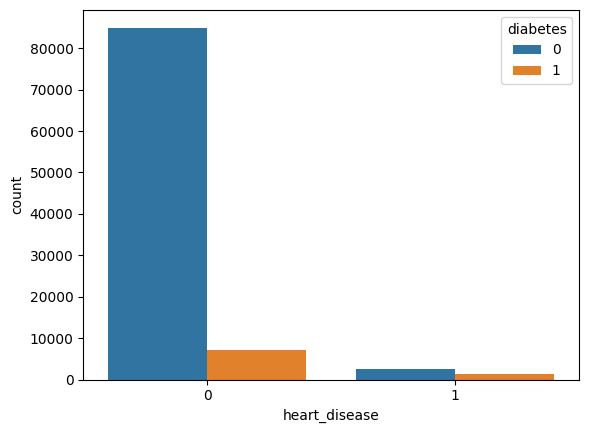

In [22]:
print(df['heart_disease'].value_counts())
sns.countplot(data = df, x = 'heart_disease', hue = 'diabetes')

In [23]:
#helper function to help display features
def plot_distribution(df, column_name):
    # Plotting distribution
    fig, ax = plt.subplots(figsize=(7, 4), nrows=1, ncols=1)
    sns.histplot(data=df, x=column_name, hue='diabetes', kde=True, bins=20)  
    plt.tight_layout()
    plt.show()


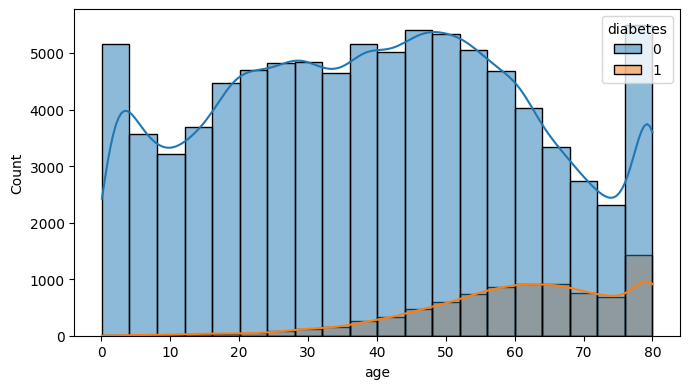

In [24]:
plot_distribution(df, 'age')

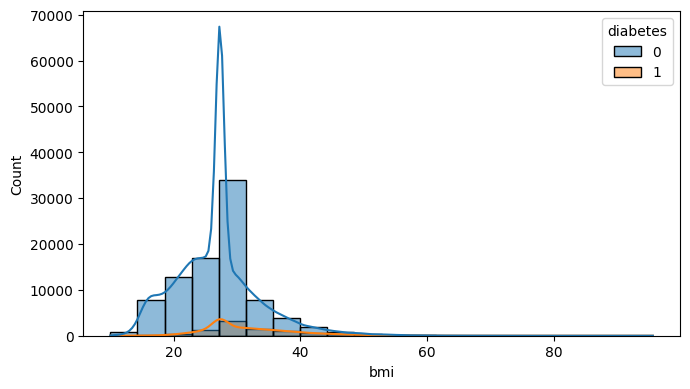

In [25]:
plot_distribution(df, 'bmi')

The boxplot shows us that the people with diabetes have a median bmi higher than those without diabetes.

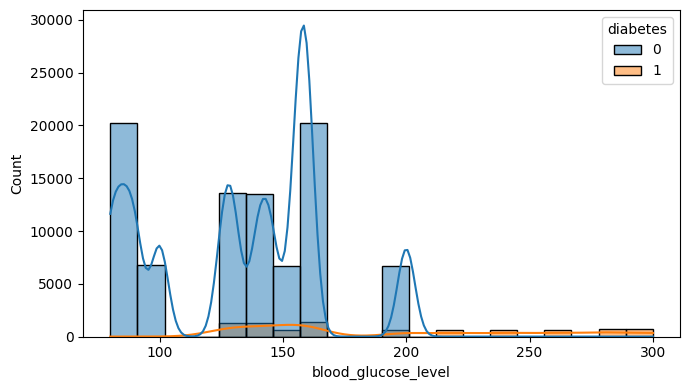

In [26]:
plot_distribution(df, 'blood_glucose_level')

note that nobody from the non-diabetic group had blood_glucose_level higher than 200

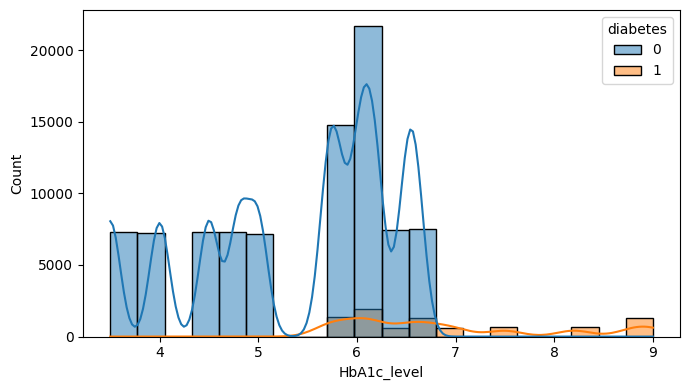

In [27]:
plot_distribution(df, 'HbA1c_level')

Nobody from the non-diabetic group had an HbA1c_level higher than approximately 7

### Target variable and evaluation metrics

In [28]:
df.diabetes.value_counts(normalize = True)

diabetes
0    0.911763
1    0.088237
Name: proportion, dtype: float64

<Axes: xlabel='diabetes'>

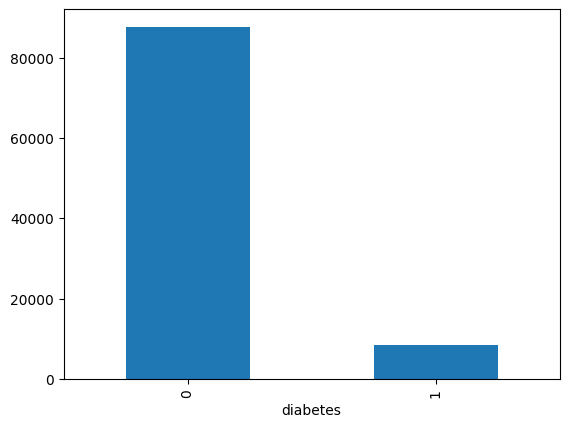

In [29]:
df['diabetes'].value_counts().plot(kind='bar')

The dataset shows that only 8.8% of cases have diabetes, making it imbalanced. This could be a problem when creating the machine learning model, as it might end up biased towards predicting the more common non-diabetic cases.

Given that only 8% of instances have diabetes in our dataset, having a higher recall becomes important to ensure that the model is good at identifying those instances, even at the cost of some precision. So, we are choosing an F-beta score with a higher beta value, like 2, is a way to address the imbalance in the data and ensure that the model's performance is evaluated with a focus on correctly identifying instances of the minority class.
In our case, accurately identifying individuals with diabetes is crucial, and we want to avoid missing any cases. While this approach might result in more false positives (higher precision), it is acceptable because diagnosing diabetes promptly ensures that patients receive timely treatment and can take necessary steps, such as adopting a healthier diet by avoiding sugary foods.

However, it's essential to note that all of the patients who are classified as having diabetes, immediate medical treatment is not advisable. Instead, it's wise for individuals to undergo further testing before beginning any treatment. This approach ensures a more precise diagnosis and allows for a personalized healthcare plan tailored to the specific needs of each person.

## Training

In [30]:
df.head(4)

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0


In [31]:
df.columns

Index(['gender', 'age', 'hypertension', 'heart_disease', 'smoking_history',
       'bmi', 'HbA1c_level', 'blood_glucose_level', 'diabetes'],
      dtype='object')

In [32]:
# Categorical features
cat_feats = ['gender','smoking_history']

# Binary features
bin_feats = ['hypertension','heart_disease']

# Numerical features
num_feats = ['age', 'bmi', 'HbA1c_level', 'blood_glucose_level']


In [33]:
y = df['diabetes'] #target variable

In [34]:
preprocessor= ColumnTransformer(
    [
        ('num','passthrough',num_feats),
        ('cat',OrdinalEncoder(),cat_feats),
        ('bin','passthrough', bin_feats)
    ],
    remainder='drop',
    verbose_feature_names_out=True
)
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor)
])

In [35]:
# Fit and transform data using the pipeline
transformed_data = pipeline.fit_transform(df)

In [36]:
feature_names = preprocessor.get_feature_names_out()
# Creating a DataFrame with the transformed data and feature names
df_transformed = pd.DataFrame(transformed_data, columns=feature_names,)

In [37]:
df_transformed.head(5)

,num__age,num__bmi,num__HbA1c_level,num__blood_glucose_level,cat__gender,cat__smoking_history,bin__hypertension,bin__heart_disease
0,80.0,25.19,6.6,140.0,0.0,4.0,0.0,1.0
1,54.0,27.32,6.6,80.0,0.0,0.0,0.0,0.0
2,28.0,27.32,5.7,158.0,1.0,4.0,0.0,0.0
3,36.0,23.45,5.0,155.0,0.0,1.0,0.0,0.0
4,76.0,20.14,4.8,155.0,1.0,1.0,1.0,1.0


In [39]:
y.shape, df_transformed.shape

((96128,), (96128, 8))

In [40]:
#splitting data into train and test
X_train,X_test,y_train,y_test = train_test_split(df_transformed, y, test_size=0.20, stratify = y, random_state = 42)


In [41]:
X_train.shape, y_train.shape

((76902, 8), (76902,))

In [42]:
#defining space for hyperparameters
space = {
    'max_depth' : hp.choice('max_depth', range(3, 8)),
    'learning_rate' : hp.quniform('learning_rate', 0.01, 0.3, 0.01),
    'n_estimators' : hp.choice('n_estimators', range(150,650)),
    'gamma' : hp.quniform('gamma', 2,10, 1),
    'subsample' : hp.quniform('subsample', 0.5, 1, 0.1),
    'colsample_bytree' : hp.quniform('colsample_bytree', 0.4, 1.0, 0.1),
    'colsample_bylevel' : hp.quniform('colsample_bylevel', 0.5, 1.0, 0.1),
    'scale_pos_weight' : hp.quniform('scale_pos_weight', 1, 10, 1)   
    }

def objective(space):
    
    
    warnings.filterwarnings(action='ignore', category=DeprecationWarning)
    classifier = xgb.XGBClassifier(n_estimators = space['n_estimators'],
                            max_depth = int(space['max_depth']),
                            learning_rate = space['learning_rate'],
                            gamma = space['gamma'],
                            subsample = space['subsample'],
                            colsample_bytree = space['colsample_bytree'],
                            colsample_bylevel = space['colsample_bylevel'],
                            scale_pos_weight = space['scale_pos_weight'], 
                            use_label_encoder = False,  eval_metric = 'logloss',
                            objective='binary:logistic'
                            )
    
    classifier.fit(X_train, y_train)

    # Applying k-Fold Cross Validation using stratifiedkfold to maintain the class distribution in each fold
    f2_scores = cross_val_score(estimator = classifier, X = X_train, y = y_train, cv = StratifiedKFold(n_splits=5, 
                                                            shuffle=True, random_state= 42), scoring = f2_scorer)
    CrossValMean = f2_scores.mean()
    print("CrossValMean:", CrossValMean)
    

    return{'loss':1-CrossValMean, 'status': STATUS_OK }

trials = Trials()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals= 100,
            trials=trials,
            verbose=True)

print("Best: ", best) 



CrossValMean:                                                                   
0.7935289475822066                                                              
CrossValMean:                                                                   
0.7984531287249386                                                              
CrossValMean:                                                                   
0.7928486327761025                                                              
CrossValMean:                                                                   
0.7806244670935245                                                              
CrossValMean:                                                                   
0.7902636510037815                                                              
CrossValMean:                                                                   
0.7921483660079396                                                              
CrossValMean:               

In [43]:
best

{'colsample_bylevel': 0.5,
 'colsample_bytree': 0.8,
 'gamma': 7.0,
 'learning_rate': 0.13,
 'max_depth': 0,
 'n_estimators': 96,
 'scale_pos_weight': 5.0,
 'subsample': 0.9}

In [44]:
clf = xgb.XGBClassifier(**best)

In [45]:
#training on train data using best hyperparameters
clf = clf.fit(X_train, y_train)

In [46]:
#predicting probablities
test_probs = clf.predict_proba(X_test)[:,1]

In [47]:
#helper func to get all the scores with different thresholds
def get_scores(y_true, y_pred_probs, thresh = 0.5):
    y_pred = [1 if i > thresh else 0 for i in y_pred_probs]
    mcc_score = matthews_corrcoef(y_true, y_pred)
    fscore = f1_score(y_true, y_pred, average='binary')
    logloss = log_loss(y_true, y_pred_probs)
    acc = accuracy_score(y_true, y_pred)
    f2 = fbeta_score(y_true, y_pred, beta=2.0, average='binary')
    print(f"The accuracy is {round(acc*100, 3)}%")
    print(f"The MCC Score is {mcc_score} ")
    print(f"The F1 Score is {fscore}")
    print(f"The F2 Score is {f2}")
    print(f"The Logloss is {logloss}")
    print("-"*50)
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    fpr = round(fp/(fp+tn),5)
    fnr = round((fn/(fn+tp)), 5)
    print(cm)
    print("-"*50)
    print(f"The FPR is {fpr*100}%")
    print(f"The FNR is {fnr*100}%")
    print("-"*50)

In [ ]:
#######

In [48]:
#with 0.5 threshold
get_scores(y_test, test_probs,)

The accuracy is 94.06%
The MCC Score is 0.6905403420111118 
The F1 Score is 0.7133534136546185
The F2 Score is 0.783179012345679
The Logloss is 0.12230232874506038
--------------------------------------------------
[[16663   867]
 [  275  1421]]
--------------------------------------------------
The FPR is 4.946%
The FNR is 16.215%
--------------------------------------------------


Our FNR is really high.  
To improve the model:   
      * we can generate more features  
      * adjust the threshold
    * add more parameters in the space for xgboost for optimization  
    * try ensembling different models (usually helps) but make the process more complex for production  
    * try getting more instances of minority class  
    * try sampling techniques (SMOTE etc)  

## Feature Importance

In [49]:
importances = clf.get_booster().get_score(importance_type="gain")
{k: v for k, v in sorted(importances.items(), key=lambda item: item[1])}

{'cat__gender': 18.57143211364746,
 'cat__smoking_history': 19.502422332763672,
 'num__bmi': 71.09886932373047,
 'bin__heart_disease': 83.66224670410156,
 'num__age': 118.40022277832031,
 'bin__hypertension': 119.72539520263672,
 'num__blood_glucose_level': 314.40130615234375,
 'num__HbA1c_level': 448.0339050292969}

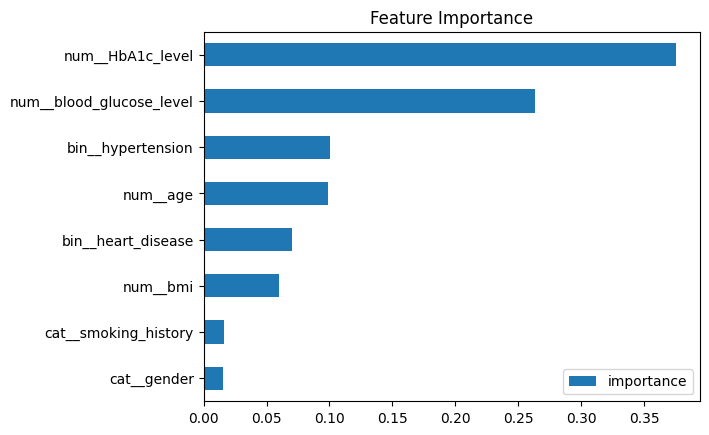

In [50]:
fi = pd.DataFrame(data = clf.feature_importances_,
             index=clf.feature_names_in_,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

Highest value of HB1c_level varible indicates that this feature has a greater impact or contribution to the model's predictions while gender has least impact.

### Finding optimal threshold

Figuring out the best threshold for imbalanced data is crucial when using models that classify things into two groups. The threshold is like a tipping point that decides if something belongs to group 0 or group 1 based on the model's guess. Usually, we start with a default threshold of 0.5—anything above it is considered group 1, and anything below is group 0. This is a common setup, but sometimes we need to adjust it for better results, especially when dealing with imbalanced situations where one group is much rarer than the other.  
As in our case instances with diabetes are only 8% of the data

In [51]:
fpr, tpr, threshold = roc_curve(y_test, test_probs)

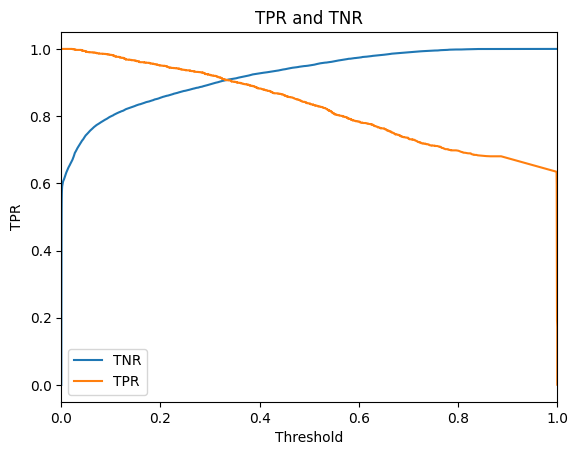

In [52]:
fpr, tpr, threshold = roc_curve(y_test, test_probs)
plt.plot(threshold, 1-fpr, label = "TNR")
plt.plot(threshold, tpr, label = "TPR")
plt.xlabel('Threshold')
# Set the y axis label of the current axis.
plt.ylabel('TPR')
plt.title('TPR and TNR')
# show a legend on the plot
plt.legend()
plt.xlim([0,1])
# Display a figure.
plt.show()

In [53]:
get_scores(y_test, test_probs, 0.4)

The accuracy is 92.333%
The MCC Score is 0.6536798372662385 
The F1 Score is 0.6699507389162561
The F2 Score is 0.7829181494661922
The Logloss is 0.12230232874506038
--------------------------------------------------
[[16256  1274]
 [  200  1496]]
--------------------------------------------------
The FPR is 7.268%
The FNR is 11.792%
--------------------------------------------------


In [55]:
get_scores(y_test, test_probs, 0.30)

The accuracy is 89.707%
The MCC Score is 0.6063846247522228 
The F1 Score is 0.6124926571372625
The F2 Score is 0.7670426679744973
The Logloss is 0.12230232874506038
--------------------------------------------------
[[15683  1847]
 [  132  1564]]
--------------------------------------------------
The FPR is 10.536%
The FNR is 7.7829999999999995%
--------------------------------------------------


0.30 is not perfect but muchhhh better than 0.5, so for now we will choose this. deninitely it can be further improved by improving the model.  
Though by choosing this number increase the false positive rate but its worth doing it as we dont want to misclassify patients with diabetes.

###  to get clean data and train model on it

In [17]:
data = jb.load("data/cleaned_data.joblib")

In [18]:
data.head()

,num__age,num__bmi,num__HbA1c_level,num__blood_glucose_level,cat__gender,cat__smoking_history,bin__hypertension,bin__heart_disease,diabetes
0,80.0,25.19,6.6,140.0,0.0,4.0,0.0,1.0,0
1,54.0,27.32,6.6,80.0,0.0,0.0,0.0,0.0,0
2,28.0,27.32,5.7,158.0,1.0,4.0,0.0,0.0,0
3,36.0,23.45,5.0,155.0,0.0,1.0,0.0,0.0,0
4,76.0,20.14,4.8,155.0,1.0,1.0,1.0,1.0,0


In [19]:
data.columns

Index(['num__age', 'num__bmi', 'num__HbA1c_level', 'num__blood_glucose_level',
       'cat__gender', 'cat__smoking_history', 'bin__hypertension',
       'bin__heart_disease', 'diabetes'],
      dtype='object')

In [21]:
feats = ['num__age', 'num__bmi', 'num__HbA1c_level', 'num__blood_glucose_level',
       'cat__gender', 'cat__smoking_history', 'bin__hypertension',
       'bin__heart_disease']
target = 'diabetes'

In [13]:
best = {'colsample_bylevel': 0.7000000000000001,
 'colsample_bytree': 0.6000000000000001,
 'gamma': 5.0,
 'learning_rate': 0.12,
 'max_depth': 0,
 'n_estimators': 88,
 'scale_pos_weight': 6.0,
 'subsample': 0.6000000000000001}

In [22]:
def create_model(X):
    train_x = X[feats]
    train_y = X[target]

    # train the model
    model = xgb.XGBClassifier(**best, objective="binary:logistic")
    model.fit(train_x, train_y)

    return model

In [23]:
model = create_model(data)

In [ ]:
#to save model
# serialize model
    with open("model.pkl", "wb") as f:
        pickle.dump(model, f)


### creating dummy test data

In [33]:
# Set a seed for reproducibility
np.random.seed(42)

# Defining the number of rows for the DataFrame
num_rows = 50

# Generate random values for each column
data_temp = {
    'gender': np.random.choice(['Male', 'Female'], size=num_rows),
    'age': np.random.randint(18, 80, size=num_rows),
    'hypertension': np.random.choice([0, 1], size=num_rows),
    'heart_disease': np.random.choice([0, 1], size=num_rows),
    'smoking_history': np.random.choice(['never', 'No Info', 'current', 'former', 'ever', 'not current'], size=num_rows),
    'bmi': np.random.uniform(12, 75, size=num_rows),
    'HbA1c_level': np.random.uniform(4, 9, size=num_rows),
    'blood_glucose_level': np.random.uniform(70, 250, size=num_rows),
}

# Create the DataFrame
test_df = pd.DataFrame(data_temp)
test_df['diabetes'] = np.nan

# Display the DataFrame
print(test_df.head())

   gender  age  hypertension  heart_disease smoking_history        bmi  \
0    Male   64             1              0           never  19.551518   
1  Female   79             1              0          former  33.269756   
2    Male   68             1              0            ever  71.403311   
3    Male   61             1              1          former  32.361785   
4    Male   72             1              0     not current  44.683809   

   HbA1c_level  blood_glucose_level  diabetes  
0     8.623468           173.842699       NaN  
1     8.386697           158.653185       NaN  
2     5.289708           105.143738       NaN  
3     7.299920           200.041381       NaN  
4     8.086111           120.539025       NaN  


In [ ]:
#transforming the test data

In [35]:
# Fit and transform data using the pipeline
transformed_data = pipeline.fit_transform(test_df)
feature_names = preprocessor.get_feature_names_out()
# Creating a DataFrame with the transformed data and feature names
df_transformed = pd.DataFrame(transformed_data, columns=feature_names,)

In [26]:
def get_predictions(model, x):
    test_prob = model.predict_proba(x)[:, 1]
    label = [1 if i > threshold else 0 for i in test_prob]

    return label

In [38]:
threshold = 0.35
get_predictions(model, df_transformed)

[1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0]

In [34]:
test_df

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Male,64,1,0,never,19.551518,8.623468,173.842699,NaN
1,Female,79,1,0,former,33.269756,8.386697,158.653185,NaN
2,Male,68,1,0,ever,71.403311,5.289708,105.143738,NaN
3,Male,61,1,1,former,32.361785,7.299920,200.041381,NaN
4,Male,72,1,0,not current,44.683809,8.086111,120.539025,NaN
5,Female,69,1,1,ever,56.290194,6.776004,74.376874,NaN
6,Male,74,1,0,ever,34.908665,6.648253,186.185013,NaN
7,Male,20,0,1,current,73.222271,5.209261,101.879922,NaN
8,Male,54,1,0,ever,72.634180,4.465514,239.282545,NaN
9,Female,68,0,0,former,27.862285,8.486079,241.707144,NaN


In [41]:
jb.dump(test_df, "data/test.joblib")

['data/test.joblib']